In [1]:
import numpy as np
from auxiliar_functions import TrainingData
import re
import os
from keras.layers import Dense
from keras.models import load_model, Sequential
from keras import backend as K
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt
from functools import partial, update_wrapper
%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.reset_default_graph()

In [3]:
model = Sequential()
model.add(Dense(10, input_shape=(868,3), activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(3, activation='tanh', name='mag'))

In [4]:
# Carregando dados para Treinamento
ANN_FOLDER = '/home/lucashqr/Documentos/Cursos/Keras Training/'\
             'Virtual/estudos-dissert/Keras_Virtual/Ciclone/ANN_DATA/'

DATA = TrainingData(ANN_FOLDER, scaler_dir='../../Models/')


# Dados de treinamento
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = DATA.data_gen(test_split=0.25, load_sc=False, save_sc=True)

print(X_TRAIN[0, :, :2].reshape(-1, 2)[0])

Shape of X_TRAIN:  (77, 868, 3)
Shape of Y_TRAIN:  (77, 868, 3)
Shape of X_TEST:  (26, 868, 3)
Shape of Y_TEST:  (26, 868, 3)
[0.32109208 0.0716555 ]


[0.49961754 0.5011504 ]
(868, 2)
(868, 3)
(52, 2)


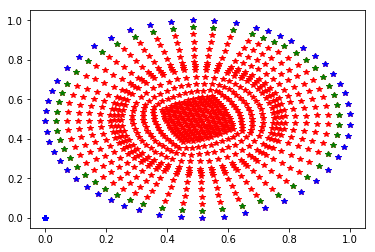

In [5]:
xz = X_TRAIN[0, :, :2]
print(np.mean(xz, axis=0))
#xz = DataFrame(xz)
print(xz.shape)
wall = []
first_line = []
A = np.array([np.mean(X_TRAIN[0, :, 0]) - np.max(X_TRAIN[0, :, 1]), 0])
for ind,pnt in enumerate(xz):    
    B = np.array(pnt) - np.array([np.mean(X_TRAIN[..., 0][0], axis=0), np.mean(X_TRAIN[..., 1])])
    B_mag = np.sqrt(np.sum(np.square(B)))
    A_mag = np.sqrt(np.sum(np.square(A)))
    
    if B_mag >= A_mag*0.99:
        tmp = [p for p in pnt]
        tmp.append(1)
        wall.append(np.array(tmp))
    else: 
        wall.append(np.array([0, 0, 0]))
    if B_mag >= A_mag*0.92 and B_mag <= A_mag*0.99:
        first_line.append([pnt])

wall = np.array(wall).reshape(-1, 3) # pontos da parede 'mais afastados do centro'
print(wall.shape)
first_line = np.array(first_line).reshape(-1, 2)
print(first_line.shape)

plt.plot(xz[:,0], xz[:,1], 'r*')
plt.plot(wall[..., 0], wall[..., 1], 'b*')
plt.plot(first_line[..., 0], first_line[..., 1], 'g*')


In [ ]:
# Função loss Customizada para magnitude
def mag_loss(y_pred, y_true, wall_val):
    """
        File: mag_isolated_prediction.py
        Function Name: mag_loss
        Summary: Função de custo para rede neural
        Description: Loss que adiciona a diferença da magnitude como penalidade
    """
    # Magnitude dos valores reais
    M_t = K.sqrt(K.sum(K.square(y_true), axis=-1))
    # Magnitude dos valores previstos
    M_p = K.sqrt(K.sum(K.square(y_pred), axis=-1))

    # Mudar pontos da parede em Booleano, para transformar em binários
    # inverter o ponto binários, para que os pontos na parede seja iguais a 0
    # e os outros pontos iguais a 1, para multiplicar pelo tensor de vel 
    wall_val = tf.cast(wall_val, dtype=tf.bool)
    wall_val = tf.expand_dims((tf.cast(wall_val, dtype=tf.float32) - 1) * -1, axis=0) # shape (1, 862, 3)
    tmp_tens = y_pred * wall_val
    # Tecnicamente 'tmp_tens'
    print(tmp_tens.get_shape())
    Penal = K.sum(K.square(y_pred - tmp_tens), axis=-1)

    return K.mean(K.square(y_pred - y_true), axis=-1) + K.abs(M_p - M_t) + Penal

In [ ]:
TB = TensorBoard(log_dir='./test_loss/Mag_zero_wall7/')
# Interromper Treinamento
ES = EarlyStopping(monitor='loss', min_delta=0.000001, patience=175,
                   restore_best_weights=True, )

# Reduzir taxa de aprendizagem
RLRP = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=70, verbose=1,
                         min_lr=1E-10)

new_mag = update_wrapper(partial(mag_loss, wall_val=wall), mag_loss)

model.compile(optimizer='rmsprop', loss={'mag':new_mag})

print('Iniciando o Treinamento')

model.fit(X_TRAIN, Y_TRAIN, epochs=300, batch_size=4, callbacks=[ES, RLRP, TB])

In [ ]:
# Gerando dados para comparação com caso original
BASE_DIR ='./test_loss/Mag_zero_wall7/'
          
print(f"Gerando dados de previsão em {BASE_DIR}")
scaler_dict = DATA.return_scaler(load_sc=True)
VEL_ARR = np.array([[10.0]*868]).reshape(-1, 1)
VEL_ARR = scaler_dict['U_in'].transform(VEL_ARR).reshape(1, -1, 1)

# Valores previstos para Ux, Uy e Uz
PREDICs = model.predict(X_TRAIN[0, :].reshape(1, -1, 3))
print([p.shape for p in PREDICs])


# Retornando os dados para a escala anterior
Ux = DataFrame(scaler_dict['Ux_scaler'].inverse_transform(PREDICs[..., 0]).reshape(-1), columns=['U:0'])
Uy = DataFrame(scaler_dict['Uy_scaler'].inverse_transform(PREDICs[..., 1]).reshape(-1), columns=['U:1'])
Uz = DataFrame(scaler_dict['Uz_scaler'].inverse_transform(PREDICs[..., 2]).reshape(-1), columns=['U:2'])

# Inserindo valor dos pontos de Y
XYZ = read_csv(os.scandir(ANN_FOLDER).__next__().path)[['Points:0', 'Points:1', 'Points:2']]

# Geração de arquivo .CSV para leitura
FILENAME = f'NEW_SLICE_10_Isolated.csv'

SLICE_DATA = concat([Ux, Uy, Uz, XYZ], sort=True, axis=1)

# Escrevendo o header no formato do paraview
with open(BASE_DIR+FILENAME, 'w') as filename:
    HEADER = ''
    for col in list(SLICE_DATA.columns):
        HEADER += '\"' + col + '\",'
    filename.write(HEADER[:-1])
    filename.write('\n')

SLICE_DATA.to_csv(BASE_DIR + FILENAME, index=False, header=False, mode='a')
print("Dados de previsão copiados!")


# Diferença do valor previsto e o caso original
print("Calculando diferença...")
ORIGIN_DATA = read_csv(ANN_FOLDER+'SLICE_DATA_U_10_0.csv')

DIFF = SLICE_DATA[['U:0', 'U:1', 'U:2']] - ORIGIN_DATA[['U:0', 'U:1', 'U:2']]

RESULT_DATA = concat([DIFF, XYZ], axis=1)

print('Escrevendo dados DIFERENÇA')
RESULT_DATA.to_csv(BASE_DIR + 'DIFF_SLICE_U_10.csv', index=False)
print('Dados de diferença copiados!')


In [ ]:
model.save(BASE_DIR+'zero_wall_loss', overwrite=True, include_optimizer=True)